In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

from tensorflow.keras.preprocessing import image
from keras.models import load_model

from skimage.morphology import skeletonize
from skan import csr
from skimage import exposure

In [2]:
import tensorflow as tf
import keras.backend as K

In [3]:
patch_size = 256


def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding,
                                      cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

### Loading the model

In [4]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [5]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        threshold = 0.5
        y_pred_binary = K.round(y_pred + 0.5 - threshold)

        intersection = K.sum(K.abs(y_true * y_pred_binary), axis=[1, 2, 3])
        total = K.sum(K.square(y_true), [1, 2, 3]) + K.sum(K.square(y_pred_binary), [1, 2, 3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())

    return K.mean(f(y_true, y_pred), axis=-1)

In [6]:
# Load the best model saved during training, providing custom metrics
model = load_model("models/occlusion.h5", custom_objects={'f1': f1, 'iou': iou})

### Single model prediction on full image

In [36]:
def process_images_in_folder(folder_path, num_images):
    # Get a list of all image files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.tif', '.jpeg'))]

    # Select a random sample of image files
    selected_files = np.random.choice(image_files, num_images, replace=False)

    for image_file in selected_files:
        # Construct the full path of the image file
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255

        # Apply your existing code
        patch_size = 256
        # image = np.expand_dims(np.expand_dims(cv2.resize(image, (256,256), interpolation=cv2.INTER_LANCZOS4),axis=0),axis=0)
        imag = np.array([cv2.resize(image, (256, 256), interpolation=cv2.INTER_LANCZOS4)]).reshape(-1, patch_size,
                                                                                                   patch_size, 1)
        print(imag.shape)
        # patches = patchify(image, (patch_size, patch_size), step=patch_size)
        # i, j = patches.shape[0], patches.shape[1]
        # patches = patches.reshape(-1, patch_size, patch_size, 1)
        preds = model.predict(imag)
        # preds = preds.reshape(i, j, 256, 256)
        # predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
        predicted_mask = preds[0] > 0.5

        # Plot the images with the image file name as the title
        fig, ax = plt.subplots(1, 2, figsize=(11, 6))
        ax[0].imshow(image, cmap="gray")
        ax[1].imshow(predicted_mask, cmap="gray")
        ax[0].axis("off")
        ax[0].set_title("Original image")
        ax[1].axis("off")
        ax[1].set_title(f"Predicted root mask - {image_file}")

        plt.show()

In [51]:
imgs = os.listdir('./test')

for el in imgs:
    original_image = cv2.imread(f'./test/{el}') 
    occlusion_image = cv2.imread(f'./test_occluded/{el}')

    Rmask = np.all(original_image == [255,255,255],  axis=-1)
    
    im = np.where(np.all(original_image == [255,255,255], axis=-1, keepdims=True), [0,255,0], [0,0,0])
    
    final_img = im + occlusion_image
    
    cv2.imwrite(f'./visual_occlusions/{el}',final_img)
    # plt.imshow(final_img)
    # plt.show()

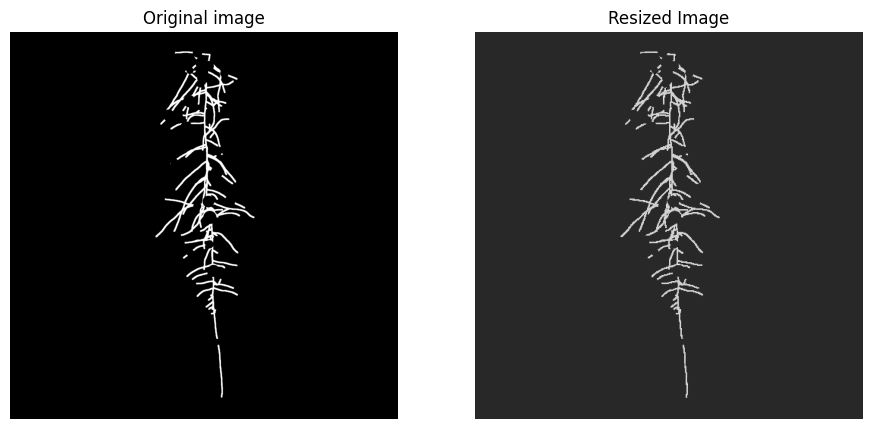

In [43]:
image = cv2.imread('./root_masks_with_occlusion/simulated_image_6.png', cv2.IMREAD_GRAYSCALE) / 255
temp = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LANCZOS4)


fig, ax = plt.subplots(1, 2, figsize=(11, 6))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(temp, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original image")
ax[1].axis("off")
ax[1].set_title(f"Resized Image")

plt.show()

(1, 256, 256, 1)
1/1 [==============================] - 0s 79ms/step


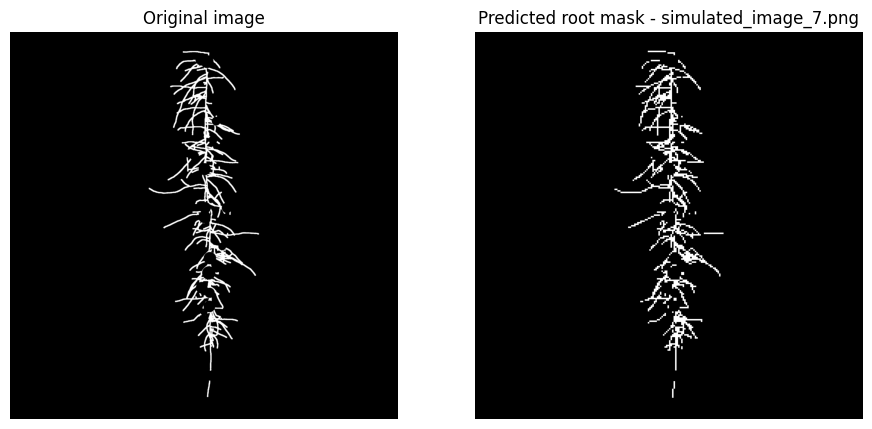

(1, 256, 256, 1)
1/1 [==============================] - 0s 81ms/step


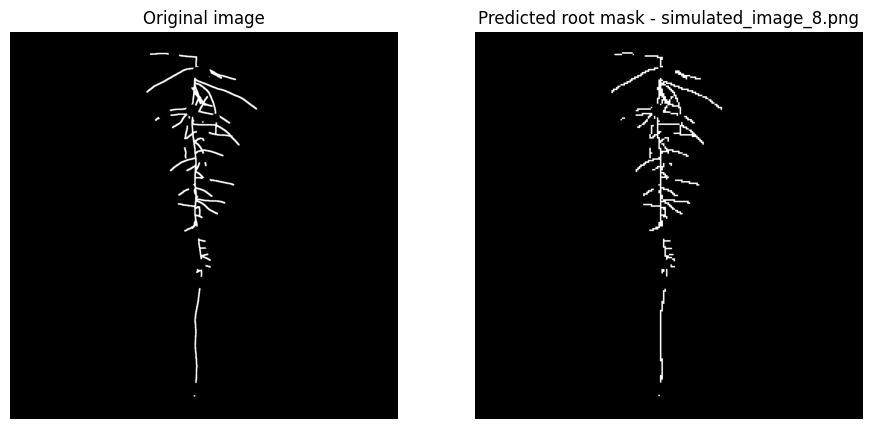

(1, 256, 256, 1)
1/1 [==============================] - 0s 78ms/step


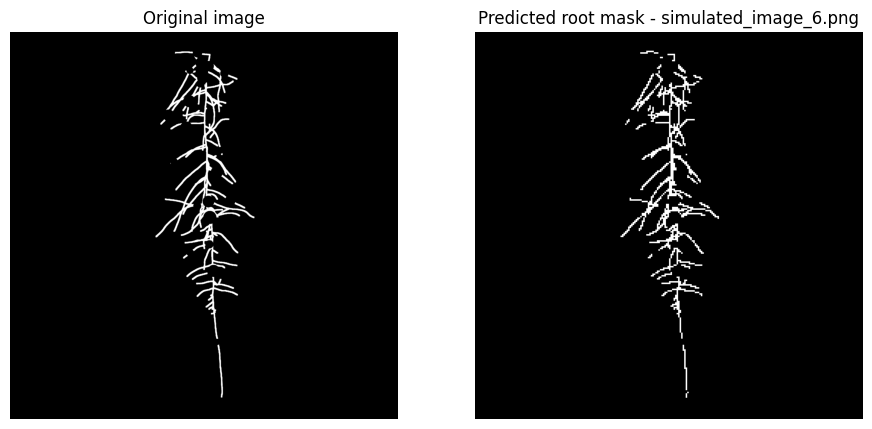

In [37]:
folder_path = 'root_masks_with_occlusion'
num_images = 3

process_images_in_folder(folder_path, num_images)


## multiple model prediction on full image

In [13]:
def process_images_in_folder_w_refinement(folder_path, num_images, refinement_steps):
    # Get a list of all image files in the specified folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.tif', '.jpeg'))]

    # Select a random sample of image files
    selected_files = np.random.choice(image_files, num_images, replace=False)

    for image_file in selected_files:
        # Construct the full path of the image file
        image_path = os.path.join(folder_path, image_file)

        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Assume 'padder' function is defined elsewhere to adjust image dimensions as needed
        patch_size = 256
        image = padder(image, patch_size)  # Adjust the image size as required
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        i, j = patches.shape[0], patches.shape[1]
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        # Initial prediction
        preds = model.predict(patches / 255)

        # Iteratively refine predictions
        for _ in range(refinement_steps):
            # Reshape predictions to match the patches layout, then predict again
            refined_patches = preds.reshape(-1, patch_size, patch_size, 1)
            preds = model.predict(refined_patches)
            preds = preds > 0.5  # Apply threshold to get binary mask

        # Final processing of predictions
        preds = preds.reshape(i, j, patch_size, patch_size)
        predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
        predicted_mask = predicted_mask > 0.5  # Apply threshold to get binary mask

        # Skeletonize the predicted mask
        skeleton = skeletonize(predicted_mask)

        # Adjust the contrast of the skeleton. This step is optional and can be adjusted or omitted.
        # Here, we're using skimage's exposure module to rescale the intensities to enhance visibility.
        # Since the skeleton is binary, this step may not have a significant effect without changing the plotting approach.
        skeleton_contrast_adjusted = exposure.rescale_intensity(skeleton.astype(np.float32), in_range=(0, 1),
                                                                out_range=(0.5, 1))

        # Plot the images with the image file name as the title
        fig, ax = plt.subplots(1, 3, figsize=(16, 6))
        ax[0].imshow(image, cmap="gray")
        ax[1].imshow(predicted_mask, cmap="gray")
        ax[2].imshow(skeleton_contrast_adjusted, cmap="hot")  # Using a different colormap for enhanced visibility
        ax[0].axis("off")
        ax[0].set_title("Original image")
        ax[1].axis("off")
        ax[1].set_title(f"Predicted root mask - {image_file}")
        ax[2].axis("off")
        ax[2].set_title(f"Skeleton - {image_file}")

        plt.show()



4/4 [==============================] - 1s 449ms/step


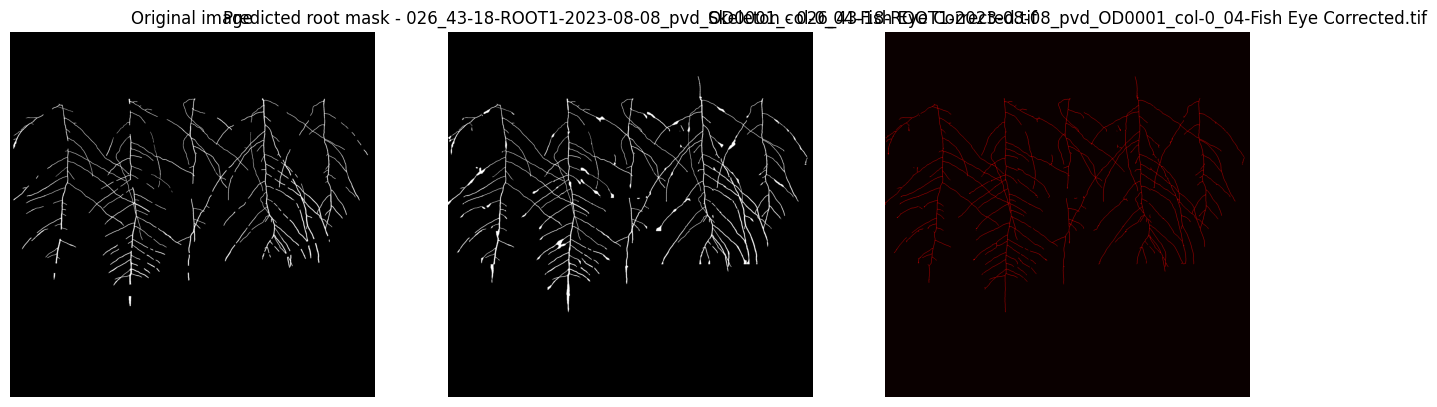

4/4 [==============================] - 1s 444ms/step


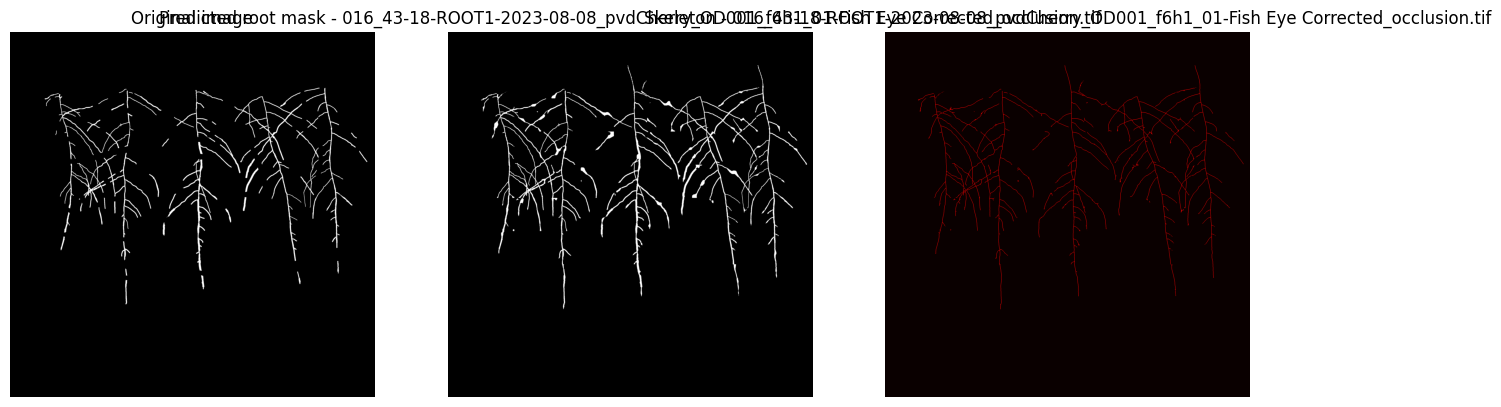

In [15]:
folder_path = 'root_masks_with_occlusion'
num_images = 2

process_images_in_folder_w_refinement(folder_path, num_images, refinement_steps=12)